In [1]:
#This is based off of Bloom lab's SARS-CoV-2 RBD DMS at: https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/process_ccs_B1351.ipynb

In [2]:
#imports
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets
import alignparse.consensus
from alignparse.utils import InFrameDeletionsToSubs


import dms_variants
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import yaml

from Bio import SeqIO

warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
'''
the considered region for error rates can be changed to only the mutated region (mut_region_mutations)
or to the entire gene (gene_mutations) - the publication uses the entire gene
'''

background = "USSR77"
#change considered region to analyze either mut_region_mutations or gene_mutations
considered_region='gene_mutations'

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using pandas version {pd.__version__}")

Using alignparse version 0.6.2
Using dms_variants version 1.4.3
Using pandas version 2.0.0


In [5]:
#open configuration file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [6]:
#make directory
os.makedirs(config['process_ccs_dir'], exist_ok=True)

In [7]:
'''
you must save the files into the config['pacbio_runs'] location in the configuration yaml file 
using the name rep#_background_runletter_ccs
'''

pacbio_runs = pd.read_csv(config['pacbio_runs'], dtype=str).drop(columns=['ccs'])
pacbio_runs['name'] = pacbio_runs['library'] + "_" + pacbio_runs['bg'] + "_" + pacbio_runs['run']
pacbio_runs['fastq'] = config['ccs_dir'] + "/" + pacbio_runs['name'] + "_ccs.fastq.gz"
pacbio_runs = pacbio_runs[pacbio_runs['bg'] == background]

pacbio_runs

,library,bg,run,name,fastq
0,rep1,USSR77,A,rep1_USSR77_A,results/ccs/rep1_USSR77_A_ccs.fastq.gz
1,rep2,USSR77,A,rep2_USSR77_A,results/ccs/rep2_USSR77_A_ccs.fastq.gz
2,rep2,USSR77,B,rep2_USSR77_B,results/ccs/rep2_USSR77_B_ccs.fastq.gz
3,rep1,USSR77,C,rep1_USSR77_C,results/ccs/rep1_USSR77_C_ccs.fastq.gz
4,rep2,USSR77,C,rep2_USSR77_C,results/ccs/rep2_USSR77_C_ccs.fastq.gz


In [8]:
print(f"Reading amplicons from {config['amplicons_' + background]}")
print(f"Reading feature parse specs from {config['feature_parse_specs_' + background]}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicons_' + background],
                feature_parse_specs=config['feature_parse_specs_' + background])

Reading amplicons from data/USSR77.gb
Reading feature parse specs from data/feature_parse_specs_USSR77.yaml


Saving plot to results/process_ccs/amplicons_USSR77.pdf


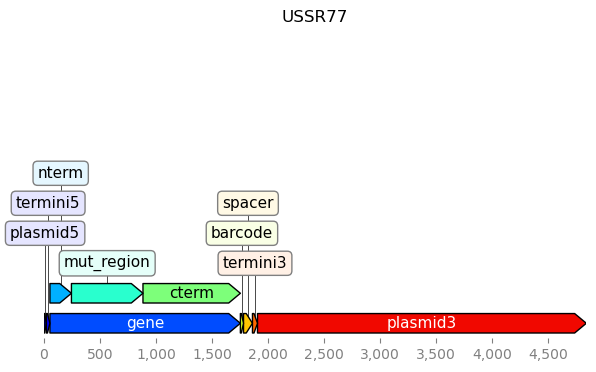

In [9]:
#generates a line plot showing the different annotations of the target, just to confirm
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=4,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['process_ccs_dir'], 'amplicons_'+background+'.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

In [10]:
#this sets the mapper to the minimap2, use OPTIONS_CODON_DMS which is good for sequences without large deletions and/or introns
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

#This will print out the minimap2 version and the options included with OPTIONS_CODON_DMS, you can find the description of these options on the Bloom lab website
print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.22-r1101 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


In [11]:
#this will align and parse the reads and provide the readstats for the aligned and filtered (based on the feature_parse_specs config)
#this is the longest step of the whole process
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

In [12]:
readstats

,name,library,run,category,count
0,rep1_USSR77_A,rep1,A,aligned USSR77,593591
1,rep1_USSR77_A,rep1,A,filtered USSR77,67202
2,rep1_USSR77_A,rep1,A,unmapped,4708
3,rep2_USSR77_A,rep2,A,aligned USSR77,90527
4,rep2_USSR77_A,rep2,A,filtered USSR77,20809
5,rep2_USSR77_A,rep2,A,unmapped,2529
6,rep2_USSR77_B,rep2,B,aligned USSR77,87430
7,rep2_USSR77_B,rep2,B,filtered USSR77,23583
8,rep2_USSR77_B,rep2,B,unmapped,2356
9,rep1_USSR77_C,rep1,C,aligned USSR77,828129


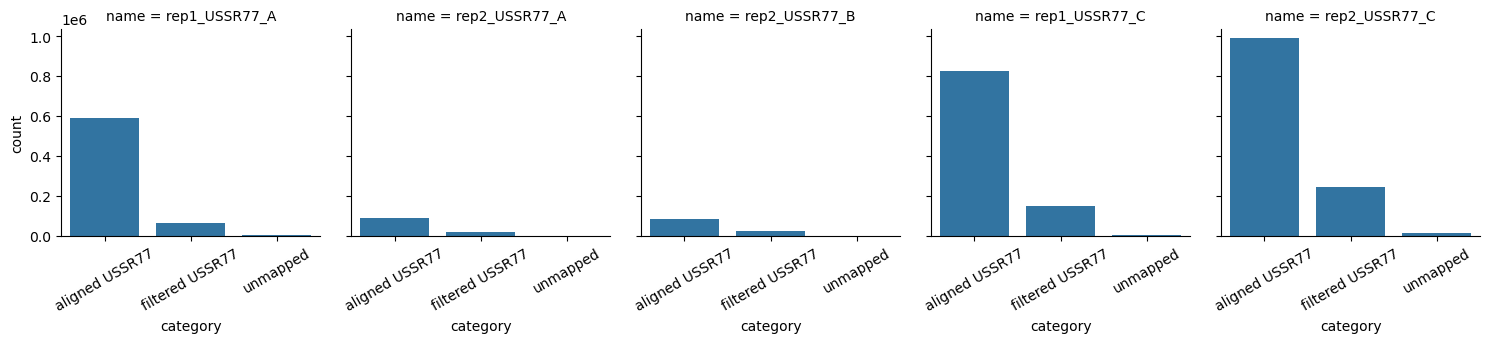

In [13]:
g = sns.FacetGrid(readstats, col='name', col_wrap=5)
g.map_dataframe(sns.barplot, x='category', y='count')
g.set_xticklabels(rotation=30)

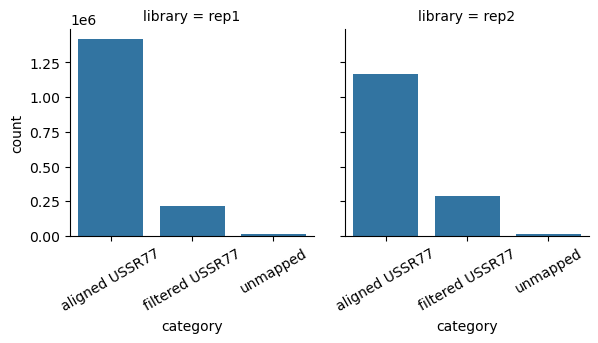

In [14]:
g = sns.FacetGrid(readstats.groupby(['library', 'category']).sum().reset_index(), col='library', col_wrap=2)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

In [15]:
filtered_df = pd.concat(df.assign(target=target) for target, df in filtered.items())
filtered_df = filtered_df.groupby(['library', 'name', 'run', 'filter_reason']).size().rename('count').reset_index()
filtered_df['tot_reason_frac'] = filtered_df.groupby('filter_reason')['count'].transform('sum') / filtered_df['count'].sum()
other_cutoff = 0.02  # group as "other" reasons with <= this frac
filtered_df['filter_reason'] = filtered_df['filter_reason'].where(filtered_df['tot_reason_frac'] > other_cutoff, 'other')

In [16]:
pd.set_option('display.max_rows', None)
filtered_df

,library,name,run,filter_reason,count,tot_reason_frac
0,rep1,rep1_USSR77_A,A,other,154,0.002761
1,rep1,rep1_USSR77_A,A,barcode mutation_nt_count,26955,0.246392
2,rep1,rep1_USSR77_A,A,other,95,0.000669
3,rep1,rep1_USSR77_A,A,gene clip3,3470,0.067514
4,rep1,rep1_USSR77_A,A,other,302,0.002938
5,rep1,rep1_USSR77_A,A,other,18,0.000094
6,rep1,rep1_USSR77_A,A,other,34,0.000270
7,rep1,rep1_USSR77_A,A,plasmid3 clip3,10838,0.229571
8,rep1,rep1_USSR77_A,A,other,11,0.000069
9,rep1,rep1_USSR77_A,A,plasmid5 clip5,18009,0.369031


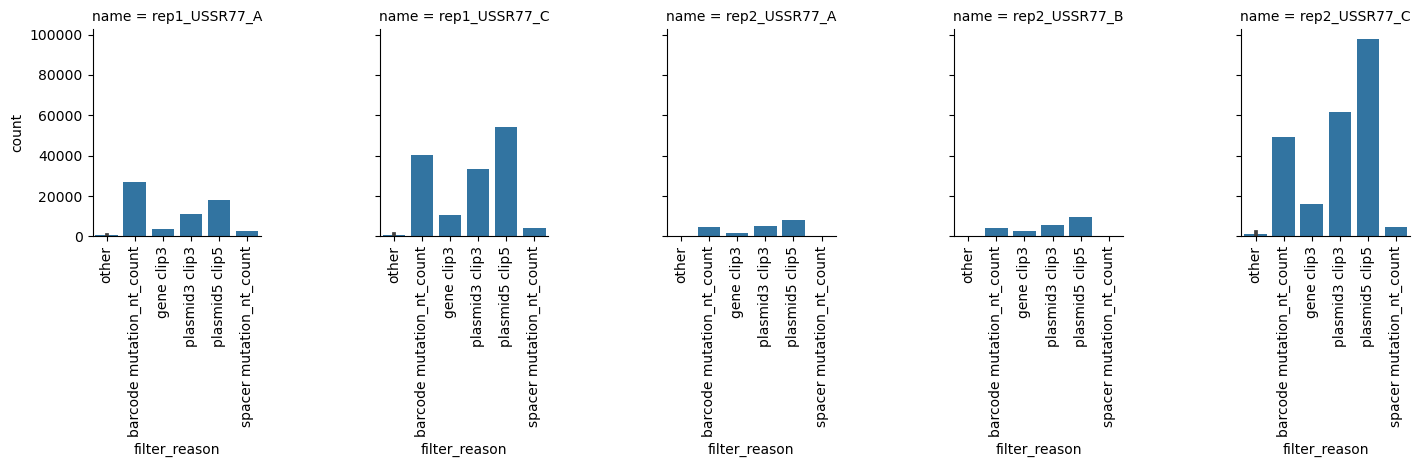

In [17]:
#plot why reads were filtered out, this can direct you to adjust the feature_parse_specs file
g = sns.FacetGrid(filtered_df, col='name')
g.map_dataframe(sns.barplot, x='filter_reason', y='count', order=filtered_df['filter_reason'].unique())
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=90)

In [18]:
pd.set_option('display.max_rows', 10)
aligned_df = pd.concat([df.assign(target=target) for target, df in aligned.items()])
aligned_df = aligned_df.drop(columns=['query_clip5', 'query_clip3', 'run','name'])
aligned_df = aligned_df.rename(columns={'barcode_sequence': 'barcode'})
aligned_df

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target
0,rep1,m64408e_230603_035327/11/ccs,del616to618,1.000000,,1.000000,del424to426,1.000000,,1.000000,GCAAAAAGCTCGAGCTGCTGCCTCCACG,1.000000,USSR77
1,rep1,m64408e_230603_035327/56/ccs,G547C T548A G549T del1039to1039 del1183to1183 ...,0.998372,,0.999996,G355C T356A G357T,0.998558,del208to208 del352to352 del422to422,0.997876,GCAATCTAGAACAGCTCGTATGTGCTCA,1.000000,USSR77
2,rep1,m64408e_230603_035327/58/ccs,A622T ins1335A,0.999700,,1.000000,A430T,1.000000,ins504A,0.999414,GCAAGAAGAGGGAGCTTTGTCATACACA,1.000000,USSR77
3,rep1,m64408e_230603_035327/64/ccs,del207to207 del532to534 del631to631 ins774A de...,0.997883,,0.999067,del15to15 del340to342 del439to439 ins582A,0.997027,del121to121 del422to422,0.998246,GCAAGCAGTGTGAGCTGAATTCAACTCG,0.999999,USSR77
4,rep1,m64408e_230603_035327/68/ccs,T775C T776A T777A,1.000000,,1.000000,T583C T584A T585A,1.000000,,1.000000,GCAACTATGGCCAGCTTCATAACGTGGA,1.000000,USSR77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589484,rep2,m64408e_231005_161422/180554575/ccs,G559T A560G G561C,1.000000,,1.000000,G367T A368G G369C,1.000000,,1.000000,GCAAATATGGGAAGCTCTATTCCCGAAG,1.000000,USSR77
2589485,rep2,m64408e_231005_161422/180554580/ccs,C216G,1.000000,,1.000000,C24G,1.000000,,1.000000,GCAATCTCGCCTAGCTCACCCAAGAATA,1.000000,USSR77
2589486,rep2,m64408e_231005_161422/180554584/ccs,ins250T T365G del757to757 ins1438G,0.999428,,0.999992,ins58T T173G del565to565,0.998713,ins607G,0.999828,GCAAGAACGATTAGCTTATCTAATCGCA,1.000000,USSR77
2589487,rep2,m64408e_231005_161422/180554585/ccs,ins525C A601G C603A C1163A,0.999941,,1.000000,ins333C A409G C411A,0.999843,C332A,1.000000,GCAATGTGTACGAGCTTAGCCCATTATC,1.000000,USSR77


In [19]:
#this saves the processed ccs file
aligned_df.to_csv(config['processed_ccs_file' + '_' + background], index=False)


print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file' + '_' + background]}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs_USSR77.csv.


In [20]:
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

In [21]:
processed_ccs = pd.read_csv(config['processed_ccs_file' + '_' + background], na_filter=None)

nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 2589489 CCSs from 2 libraries and 1 targets.


In [22]:
#displays number of CCSs and unique barcodes in all processed targets/reps
display_ccs = processed_ccs.groupby(['target', 'library']).aggregate(total_CCSs=('barcode', 'size'),
                                                                     unique_barcodes=('barcode', 'nunique'))
display_ccs['avg_CCSs_per_barcode'] = display_ccs['total_CCSs'] / display_ccs['unique_barcodes']
display_ccs['avg_CCSs_per_barcode'] = display_ccs['avg_CCSs_per_barcode'].round(2)

display_ccs

total_CCSs  unique_barcodes  avg_CCSs_per_barcode
target library                                                   
USSR77 rep1        1421720           147998                  9.61
       rep2        1167769           194131                  6.02

In [23]:
#set max_error_rate in config.yaml file

error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')
    
processed_ccs['barcode_error'] = (1-processed_ccs['barcode_accuracy']).clip(lower=error_rate_floor)
processed_ccs['gene_error'] = (1-processed_ccs['gene_accuracy']).clip(lower=error_rate_floor)

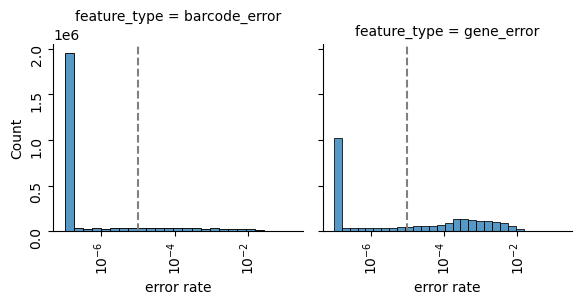

In [24]:
#plot error rates
g = sns.FacetGrid(processed_ccs.melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'), col='feature_type')
g.map_dataframe(sns.histplot, x='error rate', bins=25, log_scale=True)
g.refline(x=config['max_error_rate'])
g.tick_params(labelrotation=90)

In [25]:
processed_ccs['retained'] = ((processed_ccs['gene_error'] < config['max_error_rate']) &
                              (processed_ccs['barcode_error']    < config['max_error_rate']))

In [26]:
#retained based on error rate
data = processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library']).groupby(['xlabel', 'retained']).size().rename('count').reset_index()
data

,xlabel,retained,count
0,"USSR77, rep1",False,699747
1,"USSR77, rep1",True,721973
2,"USSR77, rep2",False,572659
3,"USSR77, rep2",True,595110


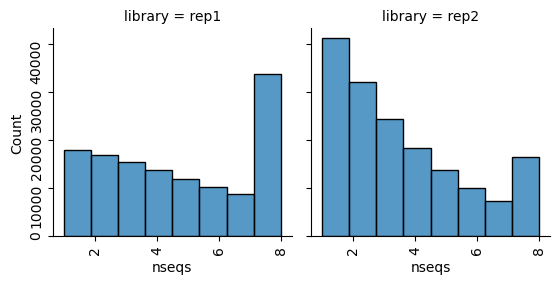

In [27]:
#plot histogram for how many barcodes have how many CCSs associated with them
max_count = 8 # in plot, group all barcodes with >= this many counts

data = processed_ccs.query('retained').groupby(['library', 'barcode']).size().rename('nseqs').reset_index()
data['nseqs'] = data['nseqs'].clip(upper=max_count)

g = sns.FacetGrid(data, col='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=8)
g.tick_params(labelrotation=90)

In [28]:
processed_ccs = processed_ccs.reset_index(drop=True)

#add indel columns, what you put as mutation_col is where it will look to see if there are indels there
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col=considered_region,
                                                       n_indel_col='n_indels',
                                                       del_str_col='del',
                                                       n_del_col='n_dels',
                                                       n_ins_col='n_ins')

processed_ccs['has_indel'] = (processed_ccs['n_indels'] > 0).astype(bool)
processed_ccs['has_ins'] = (processed_ccs['n_ins'] > 0).astype(bool)
processed_ccs['has_del'] = (processed_ccs['n_dels'] > 0).astype(bool)

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
processed_ccs

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,del,n_dels,n_ins,n_indels,has_indel,has_ins,has_del
0,rep1,m64408e_230603_035327/11/ccs,del616to618,1.000000,,1.000000,del424to426,1.000000,,1.000000,GCAAAAAGCTCGAGCTGCTGCCTCCACG,1.000000,USSR77,1.000000e-07,1.000000e-07,True,del616to618,1,0,1,True,False,True
1,rep1,m64408e_230603_035327/56/ccs,G547C T548A G549T del1039to1039 del1183to1183 ...,0.998372,,0.999996,G355C T356A G357T,0.998558,del208to208 del352to352 del422to422,0.997876,GCAATCTAGAACAGCTCGTATGTGCTCA,1.000000,USSR77,1.000000e-07,1.627897e-03,False,del1039to1039 del1183to1183 del1253to1253,3,0,3,True,False,True
2,rep1,m64408e_230603_035327/58/ccs,A622T ins1335A,0.999700,,1.000000,A430T,1.000000,ins504A,0.999414,GCAAGAAGAGGGAGCTTTGTCATACACA,1.000000,USSR77,1.000000e-07,2.997312e-04,False,,0,1,1,True,True,False
3,rep1,m64408e_230603_035327/64/ccs,del207to207 del532to534 del631to631 ins774A de...,0.997883,,0.999067,del15to15 del340to342 del439to439 ins582A,0.997027,del121to121 del422to422,0.998246,GCAAGCAGTGTGAGCTGAATTCAACTCG,0.999999,USSR77,6.058743e-07,2.117296e-03,False,del207to207 del532to534 del631to631 del952to95...,5,1,6,True,True,True
4,rep1,m64408e_230603_035327/68/ccs,T775C T776A T777A,1.000000,,1.000000,T583C T584A T585A,1.000000,,1.000000,GCAACTATGGCCAGCTTCATAACGTGGA,1.000000,USSR77,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589484,rep2,m64408e_231005_161422/180554575/ccs,G559T A560G G561C,1.000000,,1.000000,G367T A368G G369C,1.000000,,1.000000,GCAAATATGGGAAGCTCTATTCCCGAAG,1.000000,USSR77,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
2589485,rep2,m64408e_231005_161422/180554580/ccs,C216G,1.000000,,1.000000,C24G,1.000000,,1.000000,GCAATCTCGCCTAGCTCACCCAAGAATA,1.000000,USSR77,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
2589486,rep2,m64408e_231005_161422/180554584/ccs,ins250T T365G del757to757 ins1438G,0.999428,,0.999992,ins58T T173G del565to565,0.998713,ins607G,0.999828,GCAAGAACGATTAGCTTATCTAATCGCA,1.000000,USSR77,1.000000e-07,5.723872e-04,False,del757to757,1,2,3,True,True,True
2589487,rep2,m64408e_231005_161422/180554585/ccs,ins525C A601G C603A C1163A,0.999941,,1.000000,ins333C A409G C411A,0.999843,C332A,1.000000,GCAATGTGTACGAGCTTAGCCCATTATC,1.000000,USSR77,1.000000e-07,5.896410e-05,False,,0,1,1,True,True,False


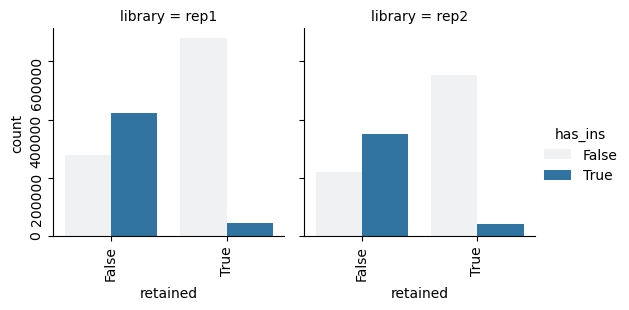

In [30]:
#plot whether the sequences retained after the error rate filter have insertions

g = sns.FacetGrid(processed_ccs, col='library')
g.map_dataframe(sns.countplot, x='retained', hue='has_ins')
g.tick_params(labelrotation=90)
g.add_legend(title='has_ins')

In [31]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no ins', 'retained and not has_ins'),
        ('10X accuracy', f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no ins', f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_ins")
        ]:
    # get just CCSs in that category
    query_df = processed_ccs.query(query_str)
        
    # compute empirical accuracy
    emp_acc_df = alignparse.consensus.empirical_accuracy(query_df,
                                                mutation_col=considered_region,
                                                group_cols='barcode',
                                                accuracy_col='accuracy',
                                               )
    emp_acc_df['description'] = desc
    query_df = emp_acc_df.merge(query_df.groupby('library').size().rename('number_CCSs').reset_index())
    empirical_acc.append(query_df)

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = pd.concat(empirical_acc, ignore_index=True, sort=False)
empirical_acc['description'] = pd.Categorical(empirical_acc['description'],
                                                 empirical_acc['description'].unique(),
                                                 ordered=True)
empirical_acc['actual'] = np.where(empirical_acc['description'] == 'retained, no ins', True, False)

In [32]:
empirical_acc

,library,accuracy,description,number_CCSs,actual
0,rep1,0.914132,retained,721973,False
1,rep2,0.900276,retained,595110,False
2,rep1,0.968756,"retained, no ins",679167,True
3,rep2,0.965434,"retained, no ins",553254,True
4,rep1,0.935019,10X accuracy,623107,False
5,rep2,0.921525,10X accuracy,513233,False
6,rep1,0.973642,"10X accuracy, no ins",596506,False
7,rep2,0.969904,"10X accuracy, no ins",486229,False


In [33]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col=considered_region,
                        )

consensus.head()

,library,barcode,target,gene_mutations,variant_call_support
0,rep1,AAAAACGAGTTCAGCTATTATGGCCCAT,USSR77,A826T A828C ins1701AGC,1
1,rep1,AAACCGCATCATAGCTTAAAGAATATAG,USSR77,C102A A295T C296G A297C ins1702GC,1
2,rep1,AAACTGTGTACGAGCTAATTCTGGCCTA,USSR77,A601C A602T C603T ins1702GC,1
3,rep1,AAAGAAACACCGAGCTATCACTTACCCT,USSR77,C421A C422T C423G ins1702GC,1
4,rep1,AAAGAGACGCTGAGCTACAAACAAAGCT,USSR77,C141G T274A C275A A276T ins1702GC,1


In [34]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col=considered_region,
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    n_ins_col='number_of_insertions',
                    n_del_col='number_of_deletions',
                    del_str_col='deletion',
                    overwrite_cols=True)

consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,deletion,number_of_deletions,number_of_insertions,number_of_indels
0,rep1,AAAAACGAGTTCAGCTATTATGGCCCAT,USSR77,A826T A828C ins1701AGC,1,A826T A828C,,0,1,1
1,rep1,AAACCGCATCATAGCTTAAAGAATATAG,USSR77,C102A A295T C296G A297C ins1702GC,1,C102A A295T C296G A297C,,0,1,1
2,rep1,AAACTGTGTACGAGCTAATTCTGGCCTA,USSR77,A601C A602T C603T ins1702GC,1,A601C A602T C603T,,0,1,1
3,rep1,AAAGAAACACCGAGCTATCACTTACCCT,USSR77,C421A C422T C423G ins1702GC,1,C421A C422T C423G,,0,1,1
4,rep1,AAAGAGACGCTGAGCTACAAACAAAGCT,USSR77,C141G T274A C275A A276T ins1702GC,1,C141G T274A C275A A276T,,0,1,1
...,...,...,...,...,...,...,...,...,...,...
270065,rep2,TTGCATCCGACGAGCTTTCATCCCATGC,USSR77,T379C C380T A381T,1,T379C C380T A381T,,0,0,0
270066,rep2,TTGCATGTAGCTAGCTCGTCCGTATCGA,USSR77,T334C T335A C336A ins1700AAGC,1,T334C T335A C336A,,0,1,1
270067,rep2,TTGCCTTGCCTCAGCTGAAGCATAGGTA,USSR77,G358A G360A,4,G358A G360A,,0,0,0
270068,rep2,TTGCGGCTTCAAAGCTCATCGCTCTGCT,USSR77,G394C A395T A396T,11,G394C A395T A396T,,0,0,0


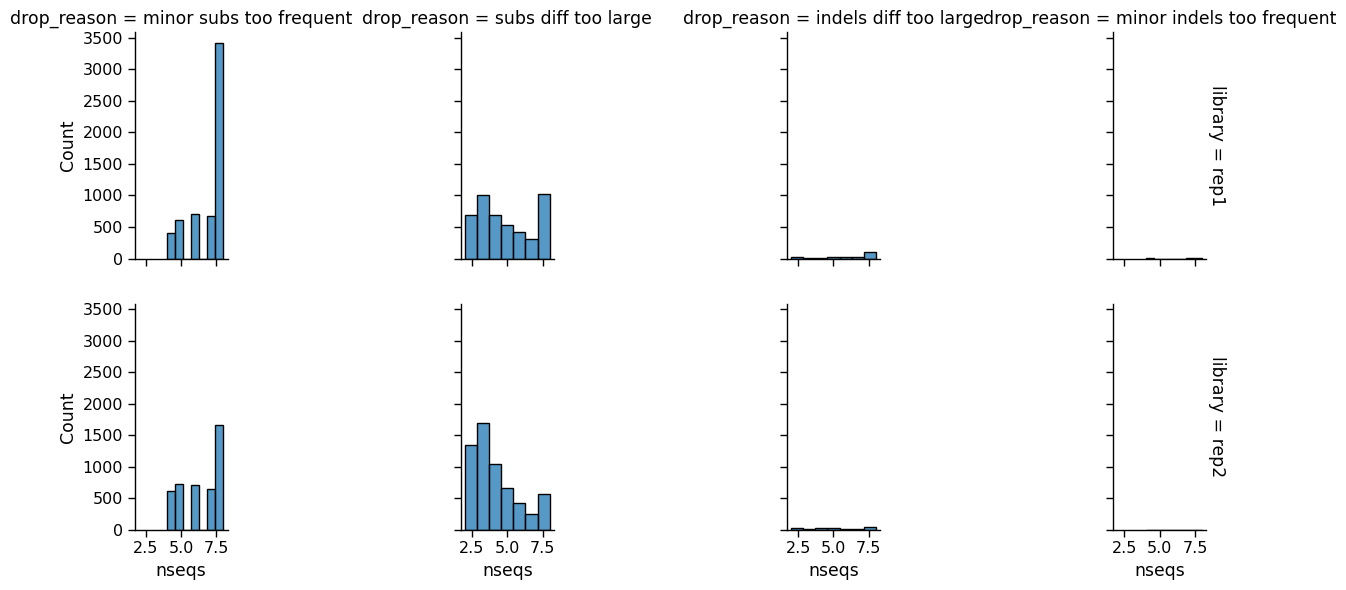

In [35]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

#below is from https://wckdouglas.github.io/2016/12/seaborn_annoying_title
with sns.plotting_context('paper', font_scale = 1.3):
    p = sns.FacetGrid(data = dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                      col = 'drop_reason',
                      row = 'library',
                      margin_titles=True)
    
p.map_dataframe(sns.histplot, x='nseqs', bins=7) 
plt.subplots_adjust(hspace=0.2, wspace=2.5)

In [36]:
max_variant_call_support = 6  # group variants with >= this much support
consensus['variant_call_support'] = consensus['variant_call_support'].clip(upper=max_variant_call_support)
consensus['ins_state'] = np.where(consensus['number_of_insertions'] > 0, 'has ins', 'no ins')

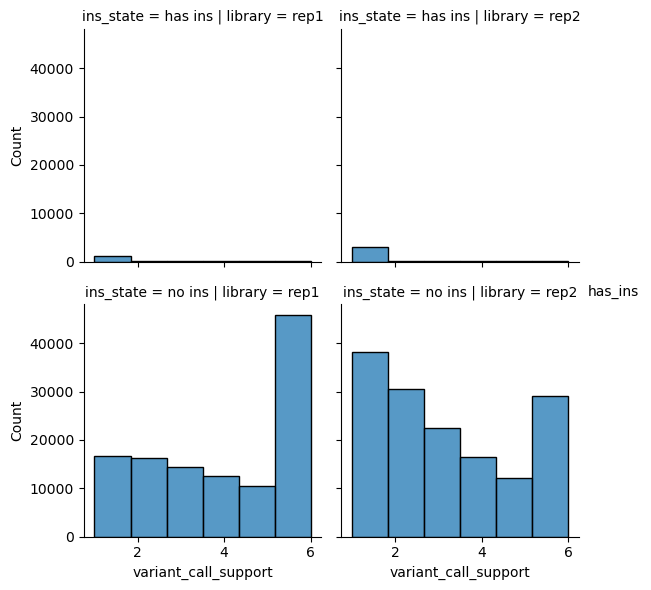

In [37]:
g = sns.FacetGrid(consensus, col='library', row='ins_state')
g.map_dataframe(sns.histplot, x='variant_call_support', bins=6)
g.add_legend(title='has_ins')

In [38]:
consensus=consensus.query('number_of_insertions == 0')
consensus=consensus.query('number_of_deletions <= 1')

In [39]:
#change dels to -, determine if deletion is out of frame and remove any that are not in frame
if considered_region == 'gene_mutations':
    region_seq = targets.get_target(background).get_feature('gene').seq
if considered_region == 'mut_region_mutations':
    region_seq = targets.get_target(background).get_feature('mut_region').seq
    
consensus.reset_index(drop=True)

deltosubs=InFrameDeletionsToSubs(region_seq)
new_subs=[]
for x in consensus[considered_region]:  
    new_subs.append(deltosubs.dels_to_subs(x))
consensus['substitutions']=new_subs
consensus['deletion_out_of_frame']=consensus['substitutions'].str.contains('del')
consensus=consensus[consensus['deletion_out_of_frame']==False]
consensus=consensus.drop(['deletion'],axis='columns')
consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_deletions,number_of_insertions,number_of_indels,ins_state,deletion_out_of_frame
38,rep1,ACAACAGAGTGCAGCTAGACGACCAACC,USSR77,C526A,1,C526A,0,0,0,no ins,False
41,rep1,ACAACTGTAAGTAGCTAGGCTGTGCGGC,USSR77,G373C T374A,4,G373C T374A,0,0,0,no ins,False
42,rep1,ACAAGATCGGTCAGCTCAGTATCTGAAT,USSR77,T647A G648T,4,T647A G648T,0,0,0,no ins,False
43,rep1,ACAAGGATTTACAGCTCGGTTCACCCAG,USSR77,A535T G536T,3,A535T G536T,0,0,0,no ins,False
44,rep1,ACAAGGATTTACAGCTTGGTTGCTACTC,USSR77,A535T G536T,1,A535T G536T,0,0,0,no ins,False
...,...,...,...,...,...,...,...,...,...,...,...
270063,rep2,TTGCATCCGACGAGCTAATTATCACCTA,USSR77,C380T A381C,6,C380T A381C,0,0,0,no ins,False
270064,rep2,TTGCATCCGACGAGCTTCTTGATCTGAT,USSR77,T379C C380A,2,T379C C380A,0,0,0,no ins,False
270065,rep2,TTGCATCCGACGAGCTTTCATCCCATGC,USSR77,T379C C380T A381T,1,T379C C380T A381T,0,0,0,no ins,False
270067,rep2,TTGCCTTGCCTCAGCTGAAGCATAGGTA,USSR77,G358A G360A,4,G358A G360A,0,0,0,no ins,False


In [40]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file' + '_' + background]}")
      
(consensus
 [['target', 'library', 'barcode', considered_region,'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file' + '_' + background], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file' + '_' + background], na_filter=None)
    .head()
    .to_html(index=False)
    )) 

Writing nucleotide variants to results/variants/nucleotide_variant_table_USSR77.csv
Here are the first few lines of this file:


target,library,barcode,gene_mutations,substitutions,variant_call_support
USSR77,rep1,ACAACAGAGTGCAGCTAGACGACCAACC,C526A,C526A,1
USSR77,rep1,ACAACTGTAAGTAGCTAGGCTGTGCGGC,G373C T374A,G373C T374A,4
USSR77,rep1,ACAAGATCGGTCAGCTCAGTATCTGAAT,T647A G648T,T647A G648T,4
USSR77,rep1,ACAAGGATTTACAGCTCGGTTCACCCAG,A535T G536T,A535T G536T,3
USSR77,rep1,ACAAGGATTTACAGCTTGGTTGCTACTC,A535T G536T,A535T G536T,1


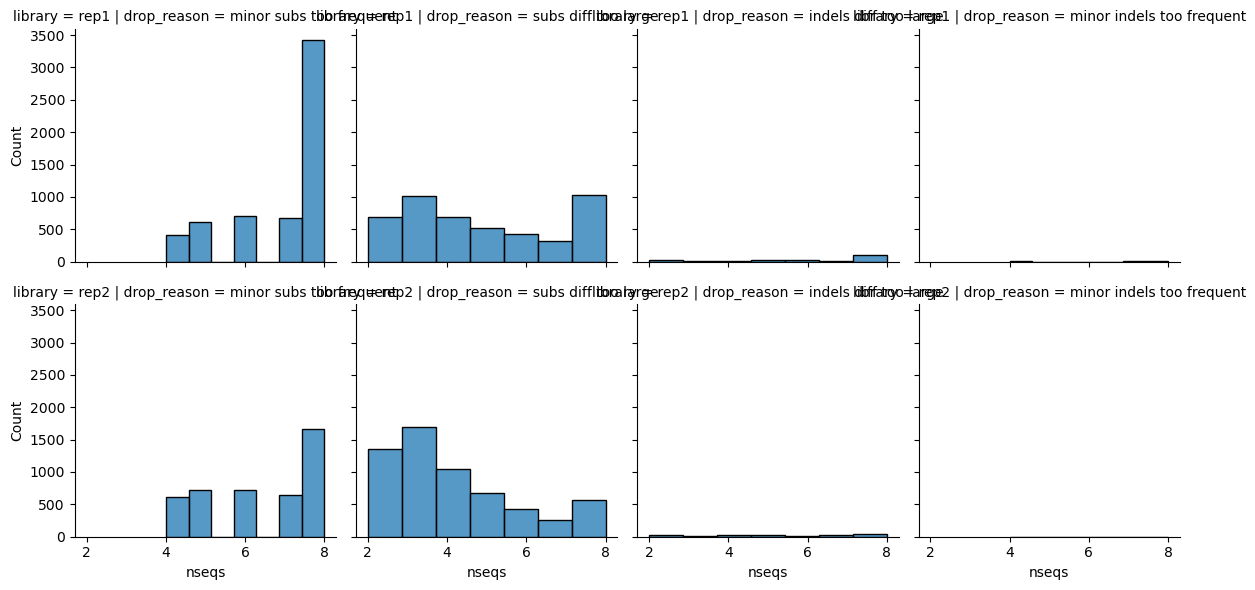

In [41]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

g = sns.FacetGrid(dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                  col='drop_reason', row='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=7)


In [42]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_' + background],
                                     feature_parse_specs=config['feature_parse_specs_' + background])
geneseq = targets.get_target(background).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {background} from {config['amplicons_' + background]}")
     

Read gene of 1701 nts for USSR77 from data/USSR77.gb


In [43]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file_' + background],
                geneseq=geneseq,
                primary_target=background,
                allowgaps=True,
                substitutions_col='substitutions'
                )

In [44]:
print('Number of variants for each replicate:')
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

Number of variants for each replicate:


library,rep1,rep2,all libraries
target,,,
USSR77,115121,147679,262800


In [45]:
variants_df=variants.barcode_variant_df
variants_df

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,USSR77,rep1,ACAACAGAGTGCAGCTAGACGACCAACC,1,CCA176ACA,P176T,1,1
1,USSR77,rep1,ACAACTGTAAGTAGCTAGGCTGTGCGGC,4,GTA125CAA,V125Q,1,1
2,USSR77,rep1,ACAAGATCGGTCAGCTCAGTATCTGAAT,4,GTG216GAT,V216D,1,1
3,USSR77,rep1,ACAAGGATTTACAGCTCGGTTCACCCAG,3,AGC179TTC,S179F,1,1
4,USSR77,rep1,ACAAGGATTTACAGCTTGGTTGCTACTC,1,AGC179TTC,S179F,1,1
...,...,...,...,...,...,...,...,...
262795,USSR77,rep2,TTGCATCCGACGAGCTAATTATCACCTA,6,TCA127TTC,S127F,1,1
262796,USSR77,rep2,TTGCATCCGACGAGCTTCTTGATCTGAT,2,TCA127CAA,S127Q,1,1
262797,USSR77,rep2,TTGCATCCGACGAGCTTTCATCCCATGC,1,TCA127CTT,S127L,1,1
262798,USSR77,rep2,TTGCCTTGCCTCAGCTGAAGCATAGGTA,4,GAG120AAA,E120K,1,1


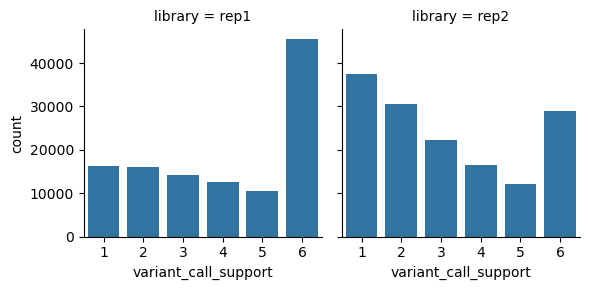

In [46]:
#show distribution of sequences with x number of ccs supporting each variant
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='variant_call_support')
g.tick_params(labelrotation=0)

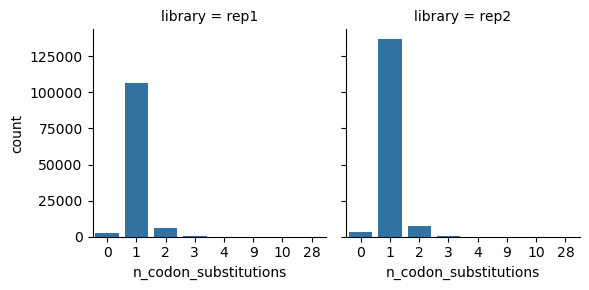

In [47]:
#show distribution of sequences with x number of codon substitutions
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='n_codon_substitutions')
g.tick_params(labelrotation=0)

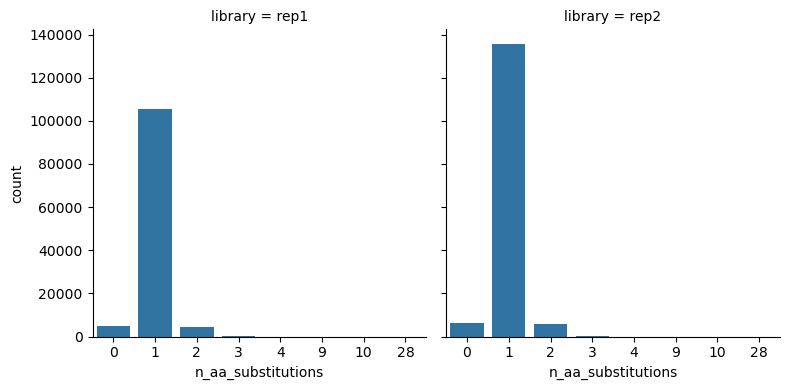

In [48]:
#show distribution of sequences with x number of amino acid substitutions
g = sns.FacetGrid(variants_df, col='library', height=4)
g.map_dataframe(sns.countplot, x='n_aa_substitutions')
g.tick_params(labelrotation=0)

In [49]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
USSR77,rep1,ACAACAGAGTGCAGCTAGACGACCAACC,1,CCA176ACA,P176T,1,1
USSR77,rep1,ACAACTGTAAGTAGCTAGGCTGTGCGGC,4,GTA125CAA,V125Q,1,1
USSR77,rep1,ACAAGATCGGTCAGCTCAGTATCTGAAT,4,GTG216GAT,V216D,1,1
USSR77,rep1,ACAAGGATTTACAGCTCGGTTCACCCAG,3,AGC179TTC,S179F,1,1
USSR77,rep1,ACAAGGATTTACAGCTTGGTTGCTACTC,1,AGC179TTC,S179F,1,1


In [50]:
print(f"Writing codon-variant table to {config['codon_variant_table_file_'+background]}")
print(f"Writing single codon-variant table to {config['codon_variant_table_file_'+background+'_single']}")


variants_df=variants.barcode_variant_df
variants_df.to_csv(config['codon_variant_table_file_'+background], index=False)
variants_df.query('n_codon_substitutions <= 1').to_csv(config['codon_variant_table_file_'+background+'_single'], index=False)

Writing codon-variant table to results/variants/codon_variant_table_USSR77.csv
Writing single codon-variant table to results/variants/codon_variant_table_USSR77_single.csv
